In [1]:
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import random
import seaborn as sns
import warnings
import time
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import stats

warnings.filterwarnings("ignore")

In [2]:
seed = 101

In [3]:
featureNames = ['no', 'age', 'gender', 'Respiration Rate', 'Blood Pressure', 'Heart Rate', 'temperature', 'hypertension', 'Diabetes Mellitus', 'Heart Disease', 'smoking', 'stroke']
df = pd.read_csv(r'dataset_fix2.csv', header=0)
del df['bloodPressure']

In [4]:
df

,no,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
0,1,76,P,20,88,36.0,1,1,1,0,1
1,2,68,p,23,70,36.0,1,1,1,0,1
2,3,62,p,20,83,36.8,1,1,0,0,1
3,4,54,L,22,88,37.0,1,0,0,0,1
4,5,83,L,18,82,36.8,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1550,1551,63,P,20,95,35.5,1,0,0,0,0
1551,1552,60,L,20,75,36.7,0,0,1,0,0
1552,1553,50,L,18,80,36.8,0,0,1,0,0
1553,1554,53,L,22,70,37.2,1,0,0,0,0


In [5]:
df.describe()

,no,age,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,778.000000,52.829582,20.181994,77.218650,36.510611,0.362058,0.022508,0.158199,0.278457,0.099035
std,449.034149,9.369569,1.748965,12.981317,0.903936,0.480750,0.148376,0.365045,0.448384,0.298806
min,1.000000,32.000000,18.000000,50.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,389.500000,46.000000,19.000000,69.000000,35.700000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,778.000000,52.000000,20.000000,75.000000,36.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1166.500000,60.000000,21.000000,85.000000,37.300000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1555.000000,92.000000,40.000000,155.000000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 1.0, 'Class Frequency\n0 : no stroke\n1: stroke')

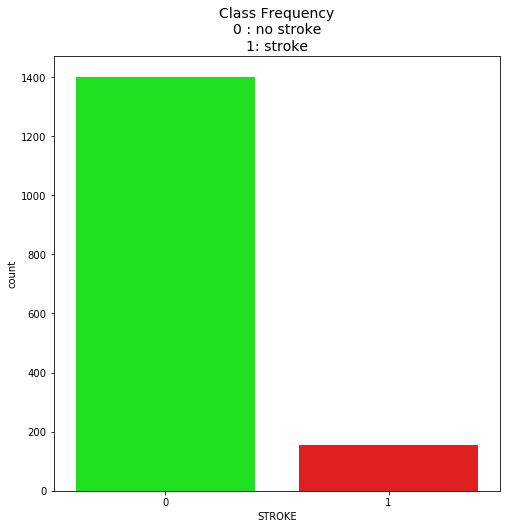

In [6]:
colors = ["#00FF00", "#FF0000"]
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot('STROKE', data=df, ax=ax, palette=colors)
plt.title('Class Frequency\n0 : no stroke\n1: stroke', fontsize=14)

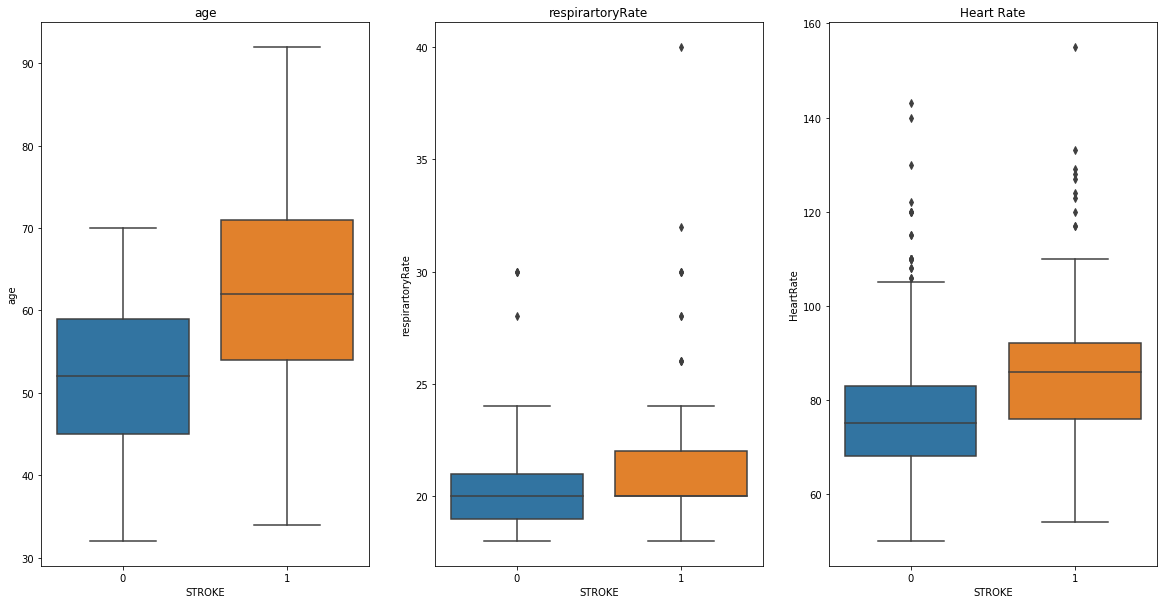

In [7]:
f, axes= plt.subplots(1, 3, figsize = (20, 10))
sns.boxplot(x="STROKE", y="age", data =df, ax=axes[0]).set_title('age')
sns.boxplot(x="STROKE", y="respirartoryRate", data =df, ax=axes[1]).set_title('respirartoryRate')
sns.boxplot(x="STROKE", y="HeartRate", data =df, ax=axes[2]).set_title('Heart Rate')
plt.show()

In [19]:
#Scaling

In [8]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df['age'] = scaler.fit_transform(df['age'].values.reshape(-1,1))
df['respirartoryRate'] = scaler.fit_transform(df['respirartoryRate'].values.reshape(-1,1))
df['HeartRate'] = scaler.fit_transform(df['HeartRate'].values.reshape(-1,1))

In [9]:
# Convert categorical values to numeric

In [10]:
gender = {'L': 0, 'P': 1}
df['gender'] = df['gender'].map(gender)

In [11]:
df.describe()

,no,age,gender,respirartoryRate,HeartRate,temperature,hypertension,dm,heartDisease,smoking,STROKE
count,1555.000000,1555.000000,1551.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,778.000000,0.059256,0.717602,0.090997,0.138666,36.510611,0.362058,0.022508,0.158199,0.278457,0.099035
std,449.034149,0.669255,0.450311,0.874482,0.811332,0.903936,0.480750,0.148376,0.365045,0.448384,0.298806
min,1.000000,-1.428571,0.000000,-1.000000,-1.562500,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,389.500000,-0.428571,0.000000,-0.500000,-0.375000,35.700000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,778.000000,0.000000,1.000000,0.000000,0.000000,36.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1166.500000,0.571429,1.000000,0.500000,0.625000,37.300000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1555.000000,2.857143,1.000000,10.000000,5.000000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Intialize Model

In [12]:
# Classifier

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Oversampling
from imblearn.over_sampling import RandomOverSampler
# Undersampling
from imblearn.under_sampling import RandomUnderSampler


Using TensorFlow backend.


In [13]:
mlp = MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(24,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=seed, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
dt = DecisionTreeClassifier()

# Oversample dataset

In [14]:
X = df
y = X.pop('STROKE')

X_res , y_res = RandomOverSampler().fit_resample(X, y)

In [ ]:
# Fit Model

In [21]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

train_acc = []
test_acc = []
for train_index, test_index in skf.split(X_res, y_res):
    model = mlp
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]

    model.fit(X_train, y_train)

    trainScore = model.score(X_train, y_train)
    testScore = model.score(X_test, y_test)
    
    train_acc.append(trainScore)
    test_acc.append(testScore)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [17]:
train_acc

[]

In [18]:
test_acc

[]

In [19]:
test_sample = np.array(X_test.loc[3]).reshape(1, -1) # ambil sampel ke 3 di X_test
test_sample

KeyError: 3

In [20]:
model.predict_proba(test_sample) # probability of negative and positive stroke

NameError: name 'test_sample' is not defined